In [1]:
import pygplates

time=60.

gmt_data = pygplates.FeatureCollection('Data/Contourites_Thran_etal_EPSL2018.gmt')

# static polygons are the 'partitioning features'
static_polygons = pygplates.FeatureCollection(
    'Data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2019_v1.shp')

# The partition_into_plates function requires a rotation model, since sometimes this would be
# necessary even at present day (for example to resolve topological polygons)
rotation_model=pygplates.RotationModel(
    ['Data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/Global_250-0Ma_Rotations_2019_v2.rot',
    'Data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/Global_410-250Ma_Rotations_2019_v2.rot'])

coastlines = pygplates.FeatureCollection(
    'Data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/StaticGeometries/Coastlines/Global_coastlines_2019_v1_low_res.shp')

# partition features
partitioned_gmt_data = pygplates.partition_into_plates(
    static_polygons,
    rotation_model,
    gmt_data,
    partition_method = pygplates.PartitionMethod.most_overlapping_plate,
    properties_to_copy = [
            pygplates.PartitionProperty.reconstruction_plate_id,
            pygplates.PartitionProperty.valid_time_period]
)

#save the contourites data with plate id and valid time period
pygplates.FeatureCollection(partitioned_gmt_data).write('contourites.gpmlz')

#reconstruct the contourites to time
pygplates.reconstruct(partitioned_gmt_data,
                      rotation_model,
                      f'contourites_{time}_Ma.gmt',
                      time) 




In [2]:

reconstructed_feature_geometries = []
pygplates.reconstruct(partitioned_gmt_data,
                      rotation_model,
                      reconstructed_feature_geometries,
                      time) 

reconstructed_coastlines = []
pygplates.reconstruct(coastlines,
                      rotation_model,
                      reconstructed_coastlines,
                      time) 

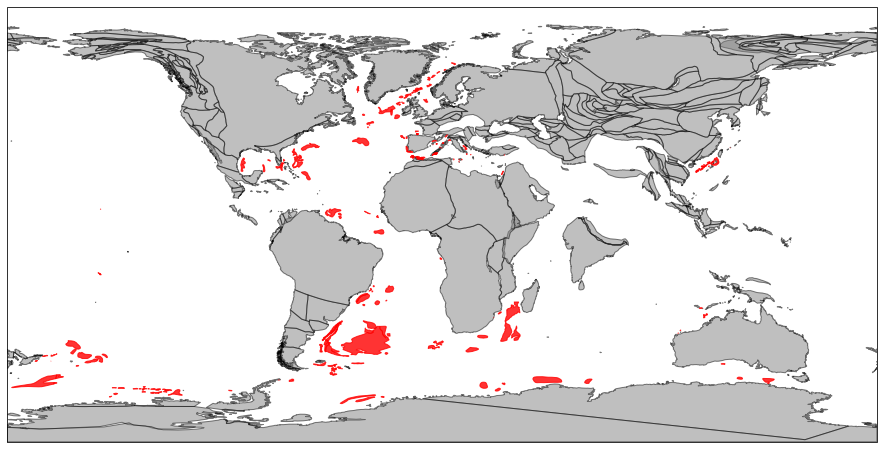

In [3]:
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from shapely.geometry.polygon import LinearRing
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

rings=[]
date_line_wrapper = pygplates.DateLineWrapper(0.0)
for polygon in reconstructed_coastlines:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        rings.append(LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()]))
              

polygons=[]
for rfg in reconstructed_feature_geometries:
    polygon = rfg.get_reconstructed_geometry()
    #get Polygon vertices and construct shapely polygon object
    polygons.append(Polygon(((lon,lat) for lat, lon in polygon.to_lat_lon_list())))

ax.add_geometries(rings, ccrs.PlateCarree(), facecolor='gray', edgecolor='black', alpha=0.5) 
ax.add_geometries(polygons, crs=ccrs.PlateCarree(), facecolor='red', edgecolor='red', alpha=0.8)

plt.show()